# Predicting user churn rates for users affiliated with schools

Users normally sign up to the Isaac Physics (IP) platform and are affiliated with a teacher that then creates groups and sets assignments. 
We are interested in establishing the importance that the teachers have on user usage of the platform. 

For our analysis, we have selected users that are in the users table who have registered in September 2016.

In this notebook, we do the following:

* Establish the churn rate of these users
* Try to predict whether given their activity in month 0, we can predict whether they will remain on the platform. 
* As such, we will establish the importance of the following features:
    * user clickstream data (actions such as questions answered, hints viewed, etc.)
    * teacher data (the activity of their teacher on the platform)
    * group data (the activity of the group that the user is on the platform)
    
Our key insights are:
* Churn rate among users who use the platform and are affiliated with a teacher is relatively low
* The initial churn rate can be well predicted using an ensemble of user cliclstream data, teacher data and group data.
* The features of the teacher carry important weight in terms of user usage of the platform
* The model performs moderately well in predicting user churn after several months of user data

## Data preparation

Here we prepare the data for subsequent analysis and determine the churn characteristics of the users.  

In [1]:
# Import key libraries
from help_lib import transform_dataframe, test_classifier, prepare_df, return_feature_importance
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

# Inputs
source_csv = '/home/andris/GitHub/data/user_teach_stuff.csv'
user_source = '/home/andris/GitHub/data/for_users.csv'


In [17]:
# Read csv into pandas dataframe
df = pd.read_csv(source_csv)
df = df.groupby(['user_id','event_leg']).sum()

# Extract the events that occured after user registration 
df_1 = df[df.index.get_level_values(1)>-1] # Activities following user registration

# Extract the events that happened before user registration, sum them and set event_leg at 0 
rep_features = ['grp_add_assig','grp_add_user','tch_add_assig','tch_add_user','tch_attempt','tch_create_group','tch_view_assig_prog']
month_array = range(int(min(df.index.get_level_values(1))),0)
df_2 = df[df.index.get_level_values(1).isin(month_array)]
df_2 = df_2.reset_index().groupby('user_id').sum()[rep_features]
df_2.columns = df_2.columns + '_tot'
df_2['event_leg'] = np.zeros(len(df_2.index))
df_2 = df_2.groupby(['user_id','event_leg']).sum()

# Add these new features to the user dataframe
for rep in rep_features:
    df_1[rep + '_tot'] = df_1[rep]
df_1 = df_1.add(df_2, fill_value=0)

# Do a cumulative sum on the features
for rep in rep_features:
    df_1[rep + '_tot'] = df_1.groupby('user_id')[rep + '_tot'].cumsum()
    
# Print the dataframe
df_1.head()

/home/andris/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


grp_add_assig  \
user_id                                            event_leg                  
0009111939b7d071597369a67002b22853c08e19f463cf2... 0.0                  0.0   
                                                   1.0                  0.0   
                                                   2.0                  0.0   
                                                   3.0                  0.0   
                                                   4.0                  0.0   

                                                              grp_add_assig_tot  \
user_id                                            event_leg                      
0009111939b7d071597369a67002b22853c08e19f463cf2... 0.0                      0.0   
                                                   1.0                      0.0   
                                                   2.0                      0.0   
                                                   3.0                      0.0   
                                                   4.0                      0.0   

                                                              grp_add_user  \
user_id                                            event_leg                 
0009111939b7d071597369a67002b22853c08e19f463cf2... 0.0                 0.0   
                                                   1.0                 0.0   
                                                   2.0                 0.0   
                                                   3.0                 0.0   
                                                   4.0                 0.0   

                                                              grp_add_user_tot  \
user_id                                            event_leg                     
0009111939b7d071597369a67002b22853c08e19f463cf2... 0.0                     0.0   
                                                   1.0                     0.0   
                                                   2.0                     0.0   
                                                   3.0                     0.0   
                                                   4.0                     0.0   

                                                              grp_added  \
user_id                                            event_leg              
0009111939b7d071597369a67002b22853c08e19f463cf2... 0.0              0.0   
                                                   1.0              0.0   
                                                   2.0              0.0   
                                                   3.0              0.0   
                                                   4.0              0.0   

                                                              play_video  \
user_id                                            event_leg               
0009111939b7d071597369a67002b22853c08e19f463cf2... 0.0               1.0   
                                                   1.0               0.0   
                                                   2.0               0.0   
                                                   3.0               0.0   
                                                   4.0               0.0   

                                                              q_lvl_0  \
user_id                                            event_leg            
0009111939b7d071597369a67002b22853c08e19f463cf2... 0.0          321.0   
                                                   1.0           50.0   
                                                   2.0          108.0   
                                                   3.0           34.0   
                                                   4.0           29.0   

                                                              q_lvl_0_cor  \
user_id                                            event_leg                
0009111939b7d071597369a67002b22853c08e19f463cf2... 0.0              137.0   
  

In [18]:
# Find the user churn from the users dataframe

# Loading the dataframe
df_user = pd.read_csv(user_source)
df_user = df_user.set_index('user_id')

# Determining the month of last activity
df_churn = np.floor((pd.to_datetime(df_user['last_seen'])  - pd.to_datetime(df_user['registration_date'])).dt.total_seconds()/(3600*24*30))
df_churn = df_churn.rename('churn_leg')

# Adding churn to the big dataframe
df = df_1.reset_index().set_index('user_id').join(df_churn)

# Eliminating events that occur after user churn
df = df[df['event_leg']<=df['churn_leg']]

# Cleaning up
df = df.drop('churn_leg',axis=1)
df = df.groupby(['user_id','event_leg']).sum()

# Printing finalised dataframe
df.head()


grp_add_assig  \
user_id                                            event_leg                  
0009111939b7d071597369a67002b22853c08e19f463cf2... 0.0                  0.0   
                                                   1.0                  0.0   
                                                   2.0                  0.0   
                                                   3.0                  0.0   
                                                   4.0                  0.0   

                                                              grp_add_assig_tot  \
user_id                                            event_leg                      
0009111939b7d071597369a67002b22853c08e19f463cf2... 0.0                      0.0   
                                                   1.0                      0.0   
                                                   2.0                      0.0   
                                                   3.0                      0.0   
                                                   4.0                      0.0   

                                                              grp_add_user  \
user_id                                            event_leg                 
0009111939b7d071597369a67002b22853c08e19f463cf2... 0.0                 0.0   
                                                   1.0                 0.0   
                                                   2.0                 0.0   
                                                   3.0                 0.0   
                                                   4.0                 0.0   

                                                              grp_add_user_tot  \
user_id                                            event_leg                     
0009111939b7d071597369a67002b22853c08e19f463cf2... 0.0                     0.0   
                                                   1.0                     0.0   
                                                   2.0                     0.0   
                                                   3.0                     0.0   
                                                   4.0                     0.0   

                                                              grp_added  \
user_id                                            event_leg              
0009111939b7d071597369a67002b22853c08e19f463cf2... 0.0              0.0   
                                                   1.0              0.0   
                                                   2.0              0.0   
                                                   3.0              0.0   
                                                   4.0              0.0   

                                                              play_video  \
user_id                                            event_leg               
0009111939b7d071597369a67002b22853c08e19f463cf2... 0.0               1.0   
                                                   1.0               0.0   
                                                   2.0               0.0   
                                                   3.0               0.0   
                                                   4.0               0.0   

                                                              q_lvl_0  \
user_id                                            event_leg            
0009111939b7d071597369a67002b22853c08e19f463cf2... 0.0          321.0   
                                                   1.0           50.0   
                                                   2.0          108.0   
                                                   3.0           34.0   
                                                   4.0           29.0   

                                                              q_lvl_0_cor  \
user_id                                            event_leg                
0009111939b7d071597369a67002b22853c08e19f463cf2... 0.0              137.0   
  

## Data analysis

Here we are interested in finding out the pattern of the data such as plotting the churn_leg of each user



array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.])

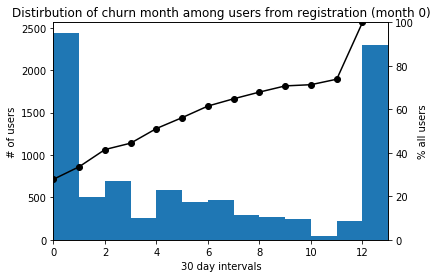

In [4]:
# Check out the churn rate
plot_churn = df.reset_index().groupby('user_id')['event_leg'].max()

# Plot the churn rate

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
n, bins, patches = ax1.hist(plot_churn, int(max(plot_churn)))
ax2.axis([0,13,0,100])
ax1.set_xlabel('30 day intervals')
ax1.set_ylabel('# of users')
ax1.set_title('Distirbution of churn month among users from registration (month 0)')
ax2.plot(range(len(bins)-1),np.cumsum(n)*100/np.sum(n),'-ok')
ax2.set_ylabel('% all users')

bins

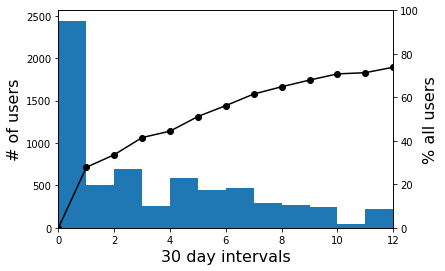

In [5]:
# Same image as above but nicer
import matplotlib

# Check out the churn rate
plot_churn = df.reset_index().groupby('user_id')['event_leg'].max()

# Plot the churn rate

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
n, bins, patches = ax1.hist(plot_churn, int(max(plot_churn)))
ax2.axis([0,12,0,100])
ax1.set_xlabel('30 day intervals',fontsize=16)
ax1.set_ylabel('# of users',fontsize=16)
#ax1.set_title('Distirbution of churn month among users from registration (month 0)')
x = np.array(range(len(bins)-1))
y = np.cumsum(n)*100/np.sum(n)
y = np.insert(y,0,0) 

ax2.plot(x,y[0:len(y)-1],'-ok')
ax2.set_ylabel('% all users',fontsize=16)
#matplotlib.rcParams.update({'font.size': 22})
fig.savefig('plot_1.png',format='png', dpi=1000)


Text(0,0.5,'# of Users Dropped Off')

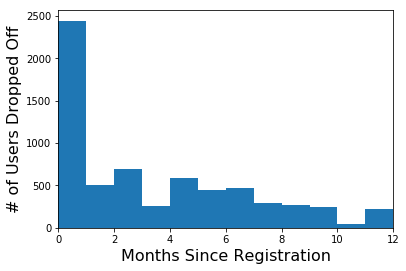

In [6]:
# Same image as above but nicer
import matplotlib

# Check out the churn rate
plot_churn = df.reset_index().groupby('user_id')['event_leg'].max()

# Plot the churn rate

fig, ax1 = plt.subplots()
n, bins, patches = ax1.hist(plot_churn, int(max(plot_churn)))
ax1.set_xlim([0,12])
ax1.set_xlabel('Months Since Registration',fontsize=16)
ax1.set_ylabel('# of Users Dropped Off',fontsize=16)

#fig.savefig('plot_1a.png',format='png', dpi=1000)


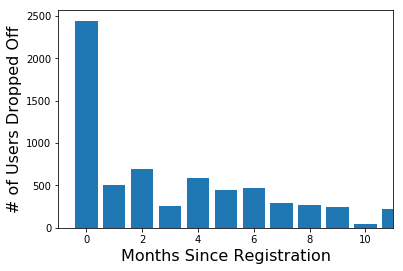

In [7]:
fig = plt.figure()
x = range(len(n))
plt.bar(x,n)
plt.xlim([-1,11])
plt.xlabel('Months Since Registration',fontsize=16)
plt.ylabel('# of Users Dropped Off',fontsize=16)
fig.savefig('plot_1a.png',format='png', dpi=600)

The churn rate is relatively linear aside from a large churn of users in the first month (around 30%). 
Ignore the last month, as some of the users are still active but they have just reached the end of our dataset. 

The churn pattern looks good, a substantial number of users remain active throughout the 12 month period. 

## Prediciting the churn rate of users after month 0

We are interested in determining whether we can predict whether users will churn after month 0. 
If we can, then we can determine which features are important in terms of determining user retention. 

### Baseline

Here we establish a baseline so that our performance metrics mean something.


In [19]:
# Given a month of data from registration period, can we predict if the user will leave the platform in the following month?
# month_array is the months of user data that we intend to train on
# df_type='append' refers to t0 adding months as features

df_trf, label = transform_dataframe(df, month_array=[0], df_type='append')

df_trf = df_trf.drop('last_month',axis=1)

df_trf.head()

,grp_add_assig_0,grp_add_assig_tot_0,grp_add_user_0,grp_add_user_tot_0,grp_added_0,play_video_0,q_lvl_0_0,q_lvl_0_cor_0,q_lvl_1_0,q_lvl_1_cor_0,...,tch_add_user_tot_0,tch_added_0,tch_attempt_0,tch_attempt_tot_0,tch_create_group_0,tch_create_group_tot_0,tch_view_assig_prog_0,tch_view_assig_prog_tot_0,view_concept_0,view_hint_0
user_id,,,,,,,,,,,,,,,,,,,,,
0009111939b7d071597369a67002b22853c08e19f463cf225f985d51a28c00e0,0.0,0.0,0.0,0.0,0.0,1.0,321.0,137.0,4.0,2.0,...,109.0,1.0,13.0,59.0,0.0,0.0,36.0,58.0,3.0,5.0
001209cc56f8583d638502e7446dd7461278082d613d4c6d718b5b3fb6d87a72,0.0,5.0,2.0,5.0,2.0,3.0,348.0,134.0,0.0,0.0,...,55.0,1.0,33.0,477.0,0.0,3.0,66.0,136.0,0.0,13.0
001ed4483f258c0e1b75a205f24f7ec2b04490adbddb45eb9bcdb91d1ff1e9be,16.0,16.0,28.0,28.0,28.0,8.0,0.0,0.0,20.0,60.0,...,226.0,4.0,42.0,698.0,0.0,6.0,92.0,180.0,0.0,88.0
00310c09b913aa7e422aa50306010d12a23ad40d63eac99e37931f0448c131df,0.0,3.0,6.0,7.0,6.0,0.0,0.0,0.0,1.0,0.0,...,50.0,0.0,2.0,75.0,0.0,4.0,0.0,66.0,1.0,6.0
003136aacdfb6e7ee06bdd001b8c5351ddb3ad360c30bcac094c645f4f1cec68,0.0,0.0,0.0,0.0,0.0,0.0,19.0,19.0,0.0,0.0,...,314.0,1.0,32.0,88.0,0.0,0.0,275.0,275.0,0.0,0.0


Number of people who have churned next month 2442
Number of people who haven't churned next month 6307


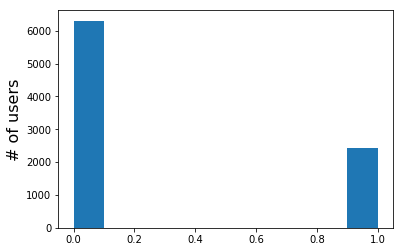

In [9]:
# Print the distribution of churned and unchurned users
fig, ax1 = plt.subplots()

plt.hist(label)
print("Number of people who have churned next month", label.count(1))
print("Number of people who haven't churned next month", label.count(0))
plt.ylabel('# of users',fontsize=16)
fig.savefig('plot_2.png',format='png', dpi=1000)


In [10]:
# Scaling the data from the transformed database before doing machine learning
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(df_trf)
y = np.array(label);

In [11]:
# Dummy classifier
from sklearn.dummy import DummyClassifier as DC

# If we guessed that every user churned
print('If we guessed that every user churned...')
n_fold=5; # number of kfolds
df_score, y_pred, clf = test_classifier(X, y, DC, n_fold, strategy='constant', constant=1)
print(df_score)

# Predicting performance if we guessed that no user churned
print('\n If we guessed that no user churned...')
n_fold=5; # number of kfolds
df_score, y_pred, clf = test_classifier(X, y, DC, n_fold, strategy='constant', constant=0)
print(df_score)

# Predicting performance if we guessed that no user churned
print('\n If we guessed randomly who churned...')
n_fold=5; # number of kfolds
df_score, y_pred, clf = test_classifier(X, y, DC, n_fold, strategy='stratified')
print(df_score)

If we guessed that every user churned...
      Accuracy  Precision  Recall
0     0.288000   0.288000     1.0
1     0.273143   0.273143     1.0
2     0.277714   0.277714     1.0
3     0.264000   0.264000     1.0
4     0.292739   0.292739     1.0
mean  0.279119   0.279119     1.0

 If we guessed that no user churned...
      Accuracy  Precision  Recall
0     0.716571        0.0     0.0
1     0.704000        0.0     0.0
2     0.725143        0.0     0.0
3     0.721143        0.0     0.0
4     0.737564        0.0     0.0
mean  0.720884        0.0     0.0

 If we guessed randomly who churned...
      Accuracy  Precision    Recall
0     0.597143   0.276730  0.268293
1     0.577143   0.267823  0.278557
2     0.579429   0.274809  0.288000
3     0.592000   0.251969  0.277056
4     0.578616   0.256863  0.267894
mean  0.584866   0.265639  0.275960


/home/andris/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### Prediciting churn rate based on all data

Here we attempt to see if we can predict the user churn rate based on all the aggregated data and features.
We try with the following machine learning algorithms

* Random forest classifier
* Support Vector Machine
* Neural network

      Accuracy  Precision    Recall
0     0.880000   0.789954  0.745690
1     0.881714   0.816705  0.733333
2     0.860571   0.769723  0.726358
3     0.866857   0.790948  0.729622
4     0.871355   0.808126  0.718876
mean  0.872100   0.795091  0.730776


([array([ 6504.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,  2245.]),
  array([ 6307.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,  2442.])],
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 2 Lists of Patches objects>)

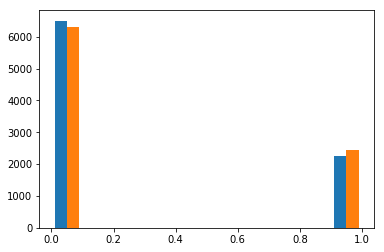

In [12]:
# Using a random forest classfier
from sklearn.ensemble import RandomForestClassifier as RF

fig, ax1 = plt.subplots()

# Prediciting performance for each k fold
n_fold=5; # number of kfolds
df_score, y_pred, clf = test_classifier(X, y, RF, n_fold, n_estimators = 500)
print(df_score)

# Printing distribution of predicited and actual users that churned at month X+1
plt.hist([y_pred,y],histtype='bar')

#plt.ylabel('# of Students')
#fig.savefig('plot_3.png',format='png', dpi=1000)


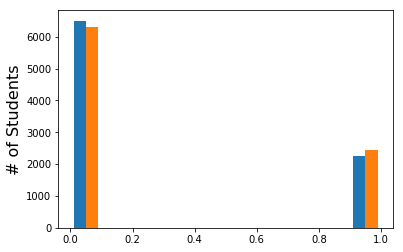

In [13]:
fig, ax1 = plt.subplots()

plt.hist([y_pred,y],histtype='bar')
plt.ylabel('# of Students',fontsize=16)
fig.savefig('plot_3.png',format='png', dpi=1000)

      Accuracy  Precision    Recall
0     0.866857   0.800895  0.713147
1     0.880571   0.806167  0.751540
2     0.865143   0.776995  0.701271
3     0.882286   0.794311  0.764211
4     0.863922   0.804545  0.699605
mean  0.871756   0.796583  0.725955


([array([ 6525.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,  2224.]),
  array([ 6307.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,  2442.])],
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 2 Lists of Patches objects>)

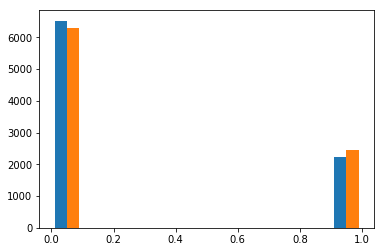

In [14]:
# Using a random forest classfier
from sklearn.ensemble import RandomForestClassifier as RF
# Prediciting performance for each k fold
n_fold=5; # number of kfolds
df_score, y_pred, clf = test_classifier(X, y, RF, n_fold, n_estimators = 500)
print(df_score)

# Printing distribution of predicited and actual users that churned at month X+1
plt.hist([y_pred,y],histtype='bar')

      Accuracy  Precision    Recall
0     0.754286   0.563636  0.510288
1     0.772000   0.587992  0.586777
2     0.766857   0.608889  0.541502
3     0.757143   0.569138  0.574899
4     0.774157   0.585746  0.557203
mean  0.764888   0.583080  0.554134


([array([ 6428.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,  2321.]),
  array([ 6307.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,  2442.])],
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 2 Lists of Patches objects>)

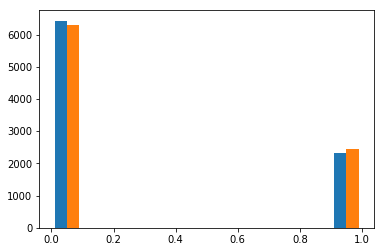

In [15]:
# Using a support vector classfier
from sklearn.svm import SVC

# Prediciting performance for each k fold
n_fold=5; # number of kfolds
df_score, y_pred, clf = test_classifier(X, y, SVC, n_fold, C = 100)
print(df_score)

# Printing distribution of predicited and actual users that churned at month X+1
plt.hist([y_pred,y],histtype='bar')

      Accuracy  Precision    Recall
0     0.800000   0.626812  0.706122
1     0.806286   0.640496  0.652632
2     0.824571   0.666012  0.712185
3     0.819429   0.664751  0.711066
4     0.829617   0.718053  0.690058
mean  0.815981   0.663225  0.694413


([array([ 6189.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,  2560.]),
  array([ 6307.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,  2442.])],
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 2 Lists of Patches objects>)

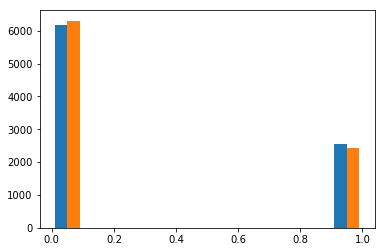

In [11]:
# Testing with a neural network
from sklearn.neural_network import MLPClassifier

# Prediciting performance for each kfold
n_fold=5;
N_dim = X.shape[1]*1
df_score, y_pred, clf = test_classifier(X, y, MLPClassifier, n_fold, solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(N_dim, 2), random_state=1)
print(df_score)

# Printing distribution
plt.hist([y_pred,y],histtype='bar')

In [16]:
# Printing feature importance as given by a random forest
return_feature_importance(X,y,df_trf.keys())

Feature ranking:
1. feature 7 (0.116814) q_lvl_0_cor_0
2. feature 6 (0.090800) q_lvl_0_0
3. feature 21 (0.077172) tch_add_assig_tot_0
4. feature 22 (0.068052) tch_add_user_0
5. feature 29 (0.064597) tch_view_assig_prog_0
6. feature 30 (0.064159) tch_view_assig_prog_tot_0
7. feature 24 (0.058750) tch_added_0
8. feature 23 (0.053610) tch_add_user_tot_0
9. feature 26 (0.049458) tch_attempt_tot_0
10. feature 20 (0.038064) tch_add_assig_0
11. feature 25 (0.037489) tch_attempt_0
12. feature 4 (0.034822) grp_added_0
13. feature 2 (0.034642) grp_add_user_0
14. feature 3 (0.034499) grp_add_user_tot_0
15. feature 0 (0.024992) grp_add_assig_0
16. feature 1 (0.024568) grp_add_assig_tot_0
17. feature 32 (0.019488) view_hint_0
18. feature 28 (0.015589) tch_create_group_tot_0
19. feature 9 (0.014826) q_lvl_1_cor_0
20. feature 8 (0.012007) q_lvl_1_0
21. feature 5 (0.010465) play_video_0
22. feature 31 (0.009361) view_concept_0
23. feature 15 (0.006756) q_lvl_4_cor_0
24. feature 10 (0.006685) q_lvl_2_0

Seems like that random forest classifier does a relatively good job of predicting user churn rates given 1 month of user data and stats regarding teach and group activity. 

The feature importance seems to suggest that the teachers are the most important in terms of encoruaging user interaction on the platform. 
The most important teacher indicators are:

* How many times that have in total and in the month looked at the assignment progress
* How many assignments they have set throughout their lifetime on the platform
* How may users they have added on the platform in that month and on their lifetime on the platform.

The least important features include:

* How many questions, outside lvl 0 the users have attempted
* How many groups the teacher has created

### Feature Engineering

Using this insight, let's try doing some feature engineering.
Does the accuracy improve if we disregard some of the user clickstream data?


      Accuracy  Precision    Recall
0     0.876571   0.810934  0.728016
1     0.873143   0.814732  0.724206
2     0.865143   0.780093  0.705021
3     0.876000   0.796421  0.738589
4     0.867353   0.790068  0.715746
mean  0.871642   0.798449  0.722316


([array([ 6540.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,  2209.]),
  array([ 6307.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,  2442.])],
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 2 Lists of Patches objects>)

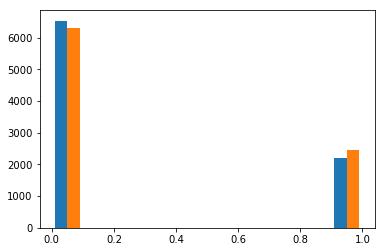

In [17]:
# Using a random forest classfier

# Removing some of the features
df_new = df_trf.drop(['q_lvl_6_cor_0','q_lvl_6_0','q_lvl_5_0','q_lvl_5_cor_0'],axis=1)

# Rescaling the features
scaler = StandardScaler()
X = scaler.fit_transform(df_new)
y = np.array(label);

# Prediciting performance for each k fold
n_fold=5; # number of kfolds
df_score, y_pred, clf = test_classifier(X, y, RF, n_fold, n_estimators = 500)
print(df_score)

# Printing distribution of predicited and actual users that churned at month X+1
plt.hist([y_pred,y],histtype='bar')

How about if we only used user clickstream data?

      Accuracy  Precision    Recall
0     0.788571   0.621924  0.580376
1     0.775429   0.608137  0.574899
2     0.781714   0.628770  0.549696
3     0.782857   0.611111  0.590909
4     0.786735   0.638695  0.556911
mean  0.783061   0.621727  0.570558


([array([ 6507.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,  2242.]),
  array([ 6307.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,  2442.])],
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 2 Lists of Patches objects>)

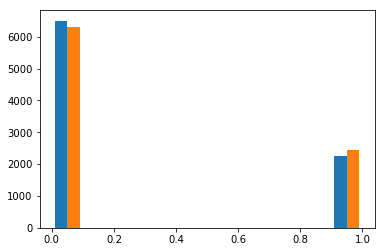

In [69]:
# Removing some of the features
df_new = df_trf.drop(['grp_add_assig_0', 'grp_add_assig_tot_0', 'grp_add_user_0',
       'grp_add_user_tot_0', 'tch_add_assig_0', 'tch_add_assig_tot_0',
       'tch_add_user_0', 'tch_add_user_tot_0',  'tch_attempt_0',
       'tch_attempt_tot_0', 'tch_create_group_0', 'tch_create_group_tot_0',
       'tch_view_assig_prog_0', 'tch_view_assig_prog_tot_0'],axis=1)

# Rescaling the features
scaler = StandardScaler()
X = scaler.fit_transform(df_new)
y = np.array(label);

# Prediciting performance for each k fold
n_fold=5; # number of kfolds
df_score, y_pred, clf = test_classifier(X, y, RF, n_fold, n_estimators = 500)
print(df_score)

# Printing distribution of predicited and actual users that churned at month X+1
plt.hist([y_pred,y],histtype='bar')

In [70]:
return_feature_importance(X,y,df_new.keys())

Feature ranking:
1. feature 2 (0.257076) q_lvl_0_0
2. feature 3 (0.252203) q_lvl_0_cor_0
3. feature 0 (0.139726) grp_added_0
4. feature 16 (0.117012) tch_added_0
5. feature 18 (0.045666) view_hint_0
6. feature 5 (0.034052) q_lvl_1_cor_0
7. feature 4 (0.028339) q_lvl_1_0
8. feature 17 (0.023049) view_concept_0
9. feature 1 (0.022975) play_video_0
10. feature 7 (0.014045) q_lvl_2_cor_0
11. feature 6 (0.012615) q_lvl_2_0
12. feature 11 (0.012454) q_lvl_4_cor_0
13. feature 10 (0.010970) q_lvl_4_0
14. feature 8 (0.009136) q_lvl_3_0
15. feature 9 (0.008178) q_lvl_3_cor_0
16. feature 13 (0.005228) q_lvl_5_cor_0
17. feature 12 (0.003586) q_lvl_5_0
18. feature 14 (0.002189) q_lvl_6_0
19. feature 15 (0.001500) q_lvl_6_cor_0


Seems like the performance takes a big hit! How about if we only used teacher data?

      Accuracy  Precision    Recall
0     0.828571   0.684959  0.699170
1     0.829143   0.716937  0.635802
2     0.826857   0.689977  0.635193
3     0.822857   0.721174  0.660269
4     0.835334   0.723596  0.661191
mean  0.828553   0.707329  0.658325


([array([ 6475.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,  2274.]),
  array([ 6307.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,  2442.])],
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 2 Lists of Patches objects>)

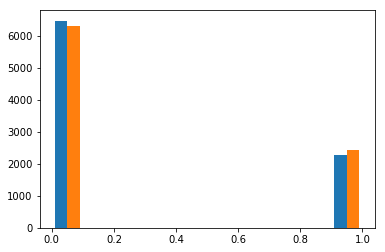

In [21]:
# Removing some of the features
df_new = df_trf.drop(['grp_add_assig_0', 'grp_add_assig_tot_0', 'grp_add_user_0',
       'grp_add_user_tot_0', 'grp_added_0', 'play_video_0', 'q_lvl_0_0',
       'q_lvl_0_cor_0', 'q_lvl_1_0', 'q_lvl_1_cor_0', 'q_lvl_2_0',
       'q_lvl_2_cor_0', 'q_lvl_3_0', 'q_lvl_3_cor_0', 'q_lvl_4_0',
       'q_lvl_4_cor_0', 'q_lvl_5_0', 'q_lvl_5_cor_0', 'q_lvl_6_0',
       'q_lvl_6_cor_0', 'view_concept_0',
       'view_hint_0'],axis=1)

# Rescaling the features
scaler = StandardScaler()
X = scaler.fit_transform(df_new)
y = np.array(label);

# Prediciting performance for each k fold
n_fold=5; # number of kfolds
df_score, y_pred, clf = test_classifier(X, y, RF, n_fold, n_estimators = 500)
print(df_score)

# Printing distribution of predicited and actual users that churned at month X+1
plt.hist([y_pred,y],histtype='bar')

Performance matches the classifier that considers all the features! What if we try to only include groups data?

      Accuracy  Precision    Recall
0     0.776000   0.671096  0.408081
1     0.794286   0.687500  0.458333
2     0.781143   0.667797  0.408714
3     0.778857   0.700658  0.418468
4     0.777587   0.649485  0.397059
mean  0.781575   0.675307  0.418131


Index(['grp_add_assig_0', 'grp_add_assig_tot_0', 'grp_add_user_0',
       'grp_add_user_tot_0', 'grp_added_0', 'play_video_0', 'q_lvl_0_0',
       'q_lvl_0_cor_0', 'q_lvl_1_0', 'q_lvl_1_cor_0', 'q_lvl_2_0',
       'q_lvl_2_cor_0', 'q_lvl_3_0', 'q_lvl_3_cor_0', 'q_lvl_4_0',
       'q_lvl_4_cor_0', 'q_lvl_5_0', 'q_lvl_5_cor_0', 'q_lvl_6_0',
       'q_lvl_6_cor_0', 'tch_add_assig_0', 'tch_add_assig_tot_0',
       'tch_add_user_0', 'tch_add_user_tot_0', 'tch_added_0', 'tch_attempt_0',
       'tch_attempt_tot_0', 'tch_create_group_0', 'tch_create_group_tot_0',
       'tch_view_assig_prog_0', 'tch_view_assig_prog_tot_0', 'view_concept_0',
       'view_hint_0'],
      dtype='object')

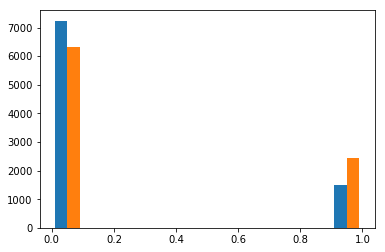

In [24]:
# Removing some of the features
df_new = df_trf.drop(['play_video_0', 'q_lvl_0_0',
       'q_lvl_0_cor_0', 'q_lvl_1_0', 'q_lvl_1_cor_0', 'q_lvl_2_0',
       'q_lvl_2_cor_0', 'q_lvl_3_0', 'q_lvl_3_cor_0', 'q_lvl_4_0',
       'q_lvl_4_cor_0', 'q_lvl_5_0', 'q_lvl_5_cor_0', 'q_lvl_6_0',
       'q_lvl_6_cor_0', 'tch_add_assig_0', 'tch_add_assig_tot_0',
       'tch_add_user_0', 'tch_add_user_tot_0', 'tch_added_0', 'tch_attempt_0',
       'tch_attempt_tot_0', 'tch_create_group_0', 'tch_create_group_tot_0',
       'tch_view_assig_prog_0', 'tch_view_assig_prog_tot_0', 'view_concept_0',
       'view_hint_0'],axis=1)

# Rescaling the features
scaler = StandardScaler()
X = scaler.fit_transform(df_new)
y = np.array(label);

# Prediciting performance for each k fold
n_fold=5; # number of kfolds
df_score, y_pred, clf = test_classifier(X, y, RF, n_fold, n_estimators = 500)
print(df_score)

# Printing distribution of predicited and actual users that churned at month X+1
plt.hist([y_pred,y],histtype='bar')
df_trf.keys()

## Prediciting churn after several months of activity

Here we want to see how the model performs when trying to predict churn after including several months of user data.


In [46]:
import time

# Constants and initial dataframe
n_fold = 5;
df_store = pd.DataFrame(columns = ['Accuracy','Precision','Recall'])
df_store_dummy = pd.DataFrame(columns = ['Accuracy','Precision','Recall'])
df_churn = pd.DataFrame(columns = ['% Churn','Total users'])

# Start the clock
start_time = time.time()
N_months = 11;
start_month=0
# Sequentially adding each month of data
for item in range(start_month,N_months): 

    # Creating months of data to encorporate
    month_array = list(range(start_month,item+1)); # Months of activity to encorporate in the model
    print('Implementing:', month_array)
    
    # Transforming dataframe
    df_trf, label = transform_dataframe(df, month_array, df_type='append')
    df_trf = df_trf.drop('last_month',axis=1)

    # Scaling the data
    scaler = StandardScaler()
    X = scaler.fit_transform(df_trf)
    y = np.array(label);
    
    # Testing on a dummy classifier
    df_score_dummy, y_pred, clf = test_classifier(X, y, DC, n_fold, strategy='stratified')
    
    # Testing on a real classifier
    N_dim = X.shape[1]*5
    #df_score, y_pred, clf = test_classifier(X, y, MLPClassifier, n_fold, solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(N_dim,), random_state=1)
    df_score, y_pred, clf = test_classifier(X, y, RF, n_fold, n_estimators = 500)

    # Storing items
    df_churn.loc['Month_'+str(item)] = [label.count(1)*100/len(label),len(label)]
    df_store.loc['Month_'+str(item)] = df_score.loc['mean'].values;
    df_store_dummy.loc['Month_'+str(item)] = df_score_dummy.loc['mean'].values;
    
    # Time?
    print((time.time()-start_time)/60,'minutes')

Implementing: [0]
0.42751331329345704 minutes
Implementing: [0, 1]
0.8124629378318786 minutes
Implementing: [0, 1, 2]
1.1984530369440713 minutes
Implementing: [0, 1, 2, 3]
1.537105135122935 minutes
Implementing: [0, 1, 2, 3, 4]
1.8975292603174845 minutes
Implementing: [0, 1, 2, 3, 4, 5]
2.3024704456329346 minutes
Implementing: [0, 1, 2, 3, 4, 5, 6]
2.65816730260849 minutes
Implementing: [0, 1, 2, 3, 4, 5, 6, 7]
2.982949630419413 minutes
Implementing: [0, 1, 2, 3, 4, 5, 6, 7, 8]
3.2840121189753213 minutes
Implementing: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
3.5892683386802675 minutes
Implementing: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


3.8104947845141095 minutes


In [47]:
df_store.join(df_store_dummy,rsuffix='_rnd').join(df_churn)

,Accuracy,Precision,Recall,Accuracy_rnd,Precision_rnd,Recall_rnd,% Churn,Total users
Month_0,0.867414,0.785695,0.722263,0.598353,0.282600,0.282162,27.911761,8749.0
Month_1,0.934431,0.705875,0.316143,0.848747,0.058060,0.054531,8.029775,6314.0
Month_2,0.901687,0.672625,0.351904,0.784784,0.108507,0.111854,11.931818,5808.0
Month_3,0.957185,0.683946,0.287281,0.906158,0.046580,0.042617,5.043988,5115.0
Month_4,0.918313,0.762568,0.482116,0.778807,0.113440,0.117043,12.160494,4860.0
Month_5,0.925848,0.819600,0.358723,0.810526,0.096598,0.100210,10.292398,4275.0
Month_6,0.911931,0.762600,0.401614,0.789217,0.116638,0.106697,12.167796,3838.0
Month_7,0.929103,0.707132,0.324338,0.835654,0.081219,0.085875,8.691783,3371.0
Month_8,0.939269,0.805050,0.415844,0.841178,0.104759,0.102500,8.769081,3079.0
Month_9,0.937367,0.762169,0.431487,0.842349,0.062276,0.056013,8.861210,2810.0


## Exploring probability thresholds

Here we look at the performance metrics of the model when we apply different probability thresholds. 



Average precision-recall score: 0.86


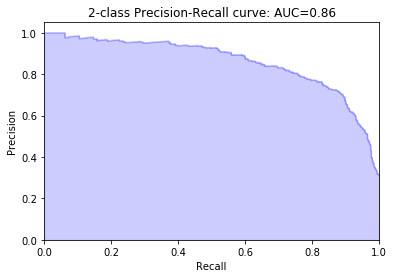

In [62]:
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score, fbeta_score
from sklearn.model_selection import train_test_split

# Transforming dataframe
df_trf, label = transform_dataframe(df, [0], df_type='append')
df_trf = df_trf.drop('last_month',axis=1)

# Scaling the data
scaler = StandardScaler()
X = scaler.fit_transform(df_trf)
y = np.array(label);

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

clf = RF(n_estimators=500)
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)
probs = clf.predict_proba(X_test)

average_precision = average_precision_score(y_test, probs[:,1])

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(y_test, probs[:,1])

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format(
          average_precision))

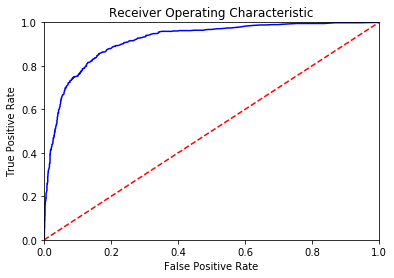

In [54]:
# Calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = roc_curve(y_test, probs[:,1])
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [71]:
# Determing the optimal threshold using the fbeta_score

fbeta_score(y_test, y_pred, average='macro', beta=100000)

ValueError: Found input variables with inconsistent numbers of samples: [2188, 8749]

## Classification

I wonder if we can perform some classification. 

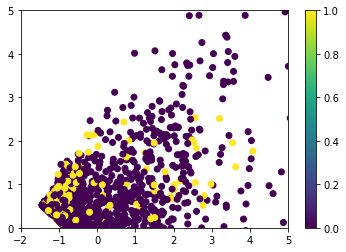

In [83]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:,0], X_pca[:,1],c= y)
plt.xlim([-2, 5])
plt.ylim([0, 5])
plt.colorbar()

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity= 800)
X_tsne = tsne.fit_transform(X)

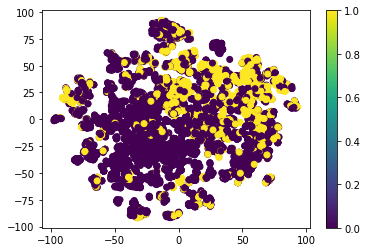

In [85]:

plt.scatter(X_tsne[:,0], X_tsne[:,1],c= y)
#plt.xlim([-2, 5])
#plt.ylim([0, 5])
plt.colorbar()